# Análise Exploratória e Pré-processamento de Dados para Regressão de Preços de Casas

Neste notebook, realizaremos uma análise exploratória de dados (EDA) e o pré-processamento para preparar o conjunto de dados de preços de casas para uma tarefa de regressão. Além disso, usaremos informações de um arquivo de descrição dos atributos para auxiliar na análise e contextualizar melhor cada variável.


In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import os
from pathlib import Path

## 1. Carregar e Analisar o Dataset
Começaremos carregando o dataset e verificando informações básicas para entender sua estrutura e os tipos de variáveis. O arquivo de descrição dos atributos será utilizado para contextualizar as colunas.

In [107]:
current_dir = Path().resolve()
data_path = os.path.join(current_dir, '..', 'data', 'regression', 'house-prices-advanced-regression-techniques', 'train.csv')

data = pd.read_csv(data_path)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 2. Distribuição da Variável Alvo (`SalePrice`)
Verificamos a distribuição da variável `SalePrice`, que representa o preço de venda das casas. Essa análise nos ajudará a identificar se a transformação é necessária devido à dispersão ou assimetria dos dados.

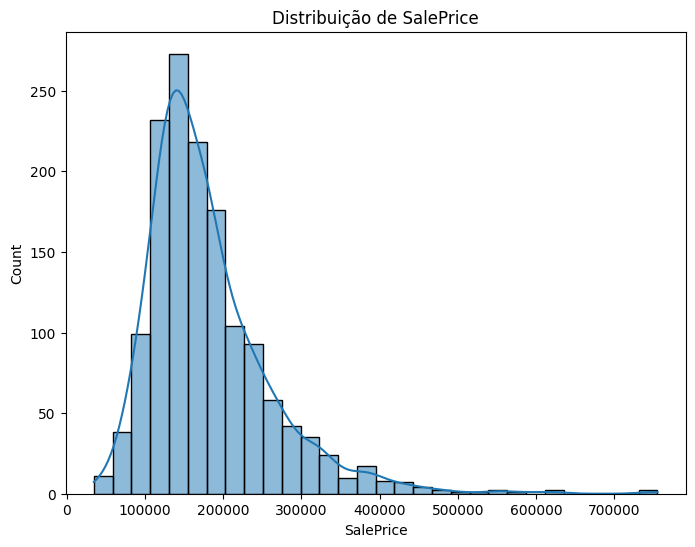

In [108]:
plt.figure(figsize=(8, 6))
sns.histplot(data['SalePrice'], kde=True, bins=30)
plt.title("Distribuição de SalePrice")
plt.show()

## 3. Tratamento de Valores Ausentes
Identificamos e tratamos os valores ausentes para melhorar a qualidade dos dados. As variáveis são ajustadas conforme necessário para garantir que não comprometam a análise posterior e a modelagem.

Define um limite para valores ausentes em cada coluna. Esse limite é calculado como 50% do total de linhas do dataset. Assim, colunas com mais de 50% de valores ausentes serão consideradas para remoção.

Cria um objeto SimpleImputer para preencher valores ausentes nas colunas numéricas. A estratégia median indica que os valores ausentes serão preenchidos com a mediana de cada coluna e Aplica o num_imputer às colunas numéricas, substituindo os valores ausentes pela mediana de cada coluna. O resultado é atribuído de volta às colunas numéricas.

Cria outro SimpleImputer para as colunas categóricas, onde os valores ausentes serão preenchidos com o valor mais frequente em cada coluna e Aplica o cat_imputer às colunas categóricas, substituindo os valores ausentes pelo valor mais frequente de cada coluna categórica.

In [109]:
missing_threshold = 0.5 * data.shape[0]
data = data.dropna(thresh=missing_threshold, axis=1)
num_features = data.select_dtypes(include=['int64', 'float64']).columns
cat_features = data.select_dtypes(include=['object']).columns
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
data[num_features] = num_imputer.fit_transform(data[num_features])
data[cat_features] = cat_imputer.fit_transform(data[cat_features])

## 4. Codificação de Variáveis Categóricas
Aplicamos One-Hot Encoding para variáveis nominais e Ordinal Encoding para variáveis com ordem natural, como `OverallQual` e `OverallCond`, que avaliam a qualidade e condição geral da casa.

**Nota:** Usamos informações da descrição dos dados para selecionar corretamente as variáveis ordinais.

Define uma lista chamada ordinal_features, contendo as variáveis OverallQual e OverallCond. Essas variáveis representam avaliações de qualidade (OverallQual) e condição geral (OverallCond) da casa e têm uma ordem natural (onde valores mais altos indicam melhores qualidades ou condições).

Cria uma lista nominal_features, que contém as variáveis categóricas que não são ordinais. cat_features representa todas as colunas categóricas, e essa linha subtrai os elementos em ordinal_features, deixando apenas as variáveis nominais, que não possuem ordem lógica.

Cria um objeto OrdinalEncoder para codificar variáveis ordinais. O OrdinalEncoder mapeia cada valor de uma variável ordinal para um número, preservando a ordem dos valores.

Aplica o OrdinalEncoder às colunas OverallQual e OverallCond, substituindo seus valores originais pelos valores numéricos codificados.

Usa pd.get_dummies para aplicar One-Hot Encoding às variáveis categóricas nominais em nominal_features. drop_first=True elimina a primeira categoria de cada variável nominal para evitar multicolinearidade nos modelos (evitando que a soma das colunas represente uma variável dependente).

In [110]:
ordinal_features = ['OverallQual', 'OverallCond']
nominal_features = list(set(cat_features) - set(ordinal_features))
ordinal_encoder = OrdinalEncoder()
data[ordinal_features] = ordinal_encoder.fit_transform(data[ordinal_features])
data = pd.get_dummies(data, columns=nominal_features, drop_first=True)

## 5. Análise de Correlação
Exploramos a matriz de correlação e destacamos as variáveis mais correlacionadas com `SalePrice`. As variáveis com forte correlação positiva, como `GrLivArea` e `OverallQual`, têm alto impacto no preço das casas, o que indica sua importância na análise e modelagem.


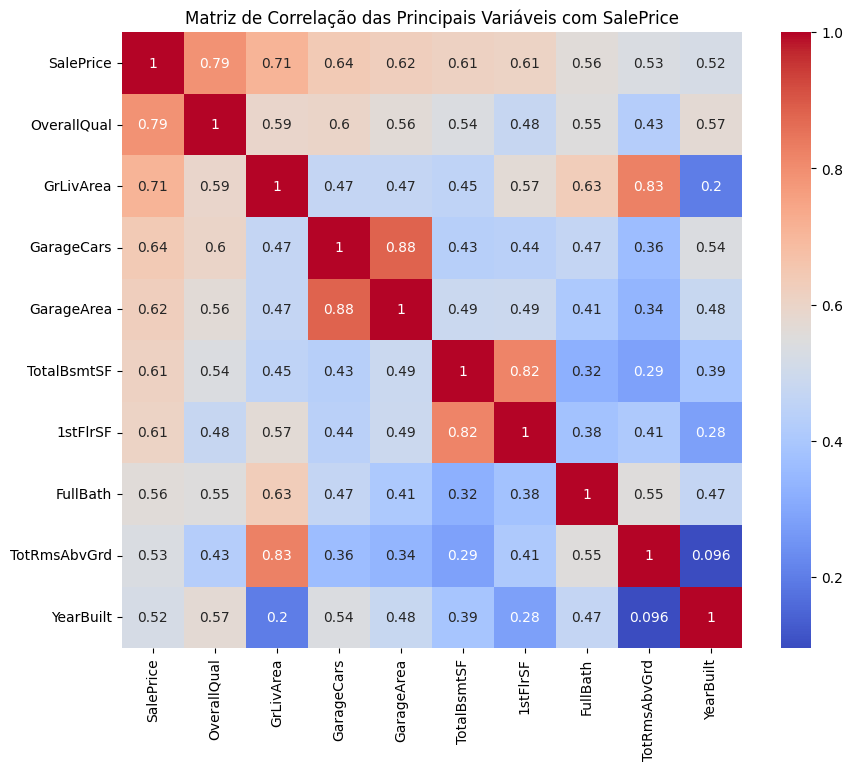

In [111]:
corr_matrix = data.corr()
high_corr_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 8))
sns.heatmap(data[high_corr_features.index].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação das Principais Variáveis com SalePrice")
plt.show()

## 6. Feature Engineering (Engenharia de Atributos)
Criadas novas variáveis derivadas de outras colunas para melhor representar aspectos estruturais das casas, como `TotalBathrooms` e `TotalSF`, que agregam áreas e banheiros. Além disso, aplicamos transformações logarítmicas em variáveis com distribuição assimétrica.

Cria uma nova coluna TotalBathrooms, que representa o total de banheiros na casa. A fórmula considera que um banheiro completo (FullBath) tem peso 1, enquanto um meio banheiro (HalfBath) tem peso 0,5. Isso permite uma única métrica para o total de banheiros, que facilita a análise.

Cria a coluna TotalSF, representando a área total da casa em pés quadrados. Soma TotalBsmtSF (área do porão), 1stFlrSF (área do primeiro andar) e 2ndFlrSF (área do segundo andar), consolidando todas as áreas para criar uma métrica abrangente de espaço.

Aplica uma transformação logarítmica à variável GrLivArea (área habitável acima do solo) usando np.log1p, que calcula o logaritmo natural de (1 + valor).
A transformação logarítmica reduz a assimetria da distribuição de GrLivArea, tornando-a mais parecida com uma distribuição normal. Isso beneficia muitos modelos de machine learning.

Aplica a mesma transformação logarítmica à variável alvo SalePrice (preço de venda da casa). Essa transformação ajuda a reduzir a influência de valores de preço extremos, beneficiando modelos que assumem uma distribuição aproximadamente normal da variável alvo.

In [112]:
data['TotalBathrooms'] = data['FullBath'] + (0.5 * data['HalfBath'])
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['GrLivArea'] = np.log1p(data['GrLivArea'])
data['SalePrice'] = np.log1p(data['SalePrice'])

## 7. Normalização e Escalonamento
Dividimos os dados em conjuntos de treino e teste e aplicamos normalização para ajustar a escala das variáveis numéricas antes da modelagem.

In [101]:
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)